                                                                                             MSC 11-2022

# Spectral Analysis

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
- [**Mathematics**](#Mathematics)
    - [**Fourier Transform**](#Fourier-Transform)
    - [**Autocorrelation Function**](#Autocorrelation-Function)
    - [**Stationary Random Processes**](#Stationary-Random-Processes)
    - [**Power Spectral Density**](#Power-Spectral-Density)
    - [<b><font color='rebeccapurple'>A Cautionary Example</b></font>](#A-Cautionary-Example)
    - [**Stationarity Tests**](#Stationarity-Tests)
- [**PSDs in Openseize**](#PSDs-in-Openseize)
- [**STFT & Spectrograms**](#STFT-&-Spectrograms)
- [**References**](#References)

## Imports

In [1]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from openseize import producer
from openseize.io.edf import Reader
from openseize import demos
from openseize.spectra import estimators

## Introduction

This tutorial covers the mathematics and application of spectral estimation in Openseize. In contrast with previous tutorials, all readers are strongly encouraged to read through the mathematics section of this tutorial. There we discuss EEG data stationarity, a critical issue that must be addressed before constructing power spectral density estimates. As usual, this tutorial covers a lot of ground in signal processing and curious readers will find better and more complete explanations of the topics discussed here in the references section.


## Mathematics

### Fourier Transform

In the resampling demo, we used the Fourier Transform. This integral transform is critical to spectral analysis so we formally define it here. The <b>Fourier Transform</b> of a continuous signal is:
<br>
<br>
<p style="text-align: center;">
    $
    X^F(\omega) = \{\mathcal{F}\}x(\omega) = \int \limits_{-\infty}^{\infty} x(t)e^{-i\omega t}dt \quad (1)
    $ 
</p>
<br>
<br>
This transform takes the continuous-time signal $x(t)$ and recast it in the frequency domain $X^F(\omega)$ where $\omega$ is the angular frequency (radians/sec) and $f = \frac{\omega}{2 \pi}$ is in Hertz. For discrete signals $x[n]$ there is a complementary discrete transform defined as:
<br>
<br>
<p style="text-align: center;">
    $
    X^F(\theta) = \{\mathcal{F}\}x(\theta) = \sum \limits_{n=-\infty}^{\infty} x(n)e^{-i\theta n} \quad (2)
    $ 
</p>
<br>
<br>
Here $\theta$ is a continuous variable that runs from 0 to $2 \pi$. Since, we can't hold all possible $\theta s$ we also sample the frequencies at N equally spaced points:
<br>
<br>
<p style="text-align: center;">
    $
        \theta[k] = \frac{2\pi k}{N} \quad 0 \leq k \leq N-1 \quad (3)
    $ 
</p>
<br>
<br>
Substituting this into (2) gives us the formal <b>Discrete Time Fourier Transform</b>: 
<br>
<br>
<p style="text-align: center;">
    $
    X^d(k) = \sum \limits_{n=0}^{N-1} x(n)e^{\frac{-i 2 \pi k n}{N}} \quad (4)
    $ 
</p>
<br>
<br>
Here we think of Eqn (4) as just a sampling of $X^F(\theta)$ in Eqn. (2) at N points called the number of DFT points. In this tutorial we call these N DFT-points "NFFT" to make clear they refer to the number of sampling points used in the DFT. This sampling determines the <b>Resolution $\Delta f$</b> of the frequencies in the Fourier domain. Specifically, 
<br>
<br>
<p style="text-align: center;">
    $
    \Delta f = \frac{fs}{NFFT} \quad (5)
    $ 
</p>
<br>
<br>
Where fs is the sampling frequency in Hertz. Lets now take a little example to understand what exactly the DFT does to a discrete time signal. Below we make a 3 Hz signal that is contaminated by noise from a Gaussian distribution with standard deviation of 2. Our goal here is to understand the representation of this signal in the Fourier domain after carrying out the DFT.

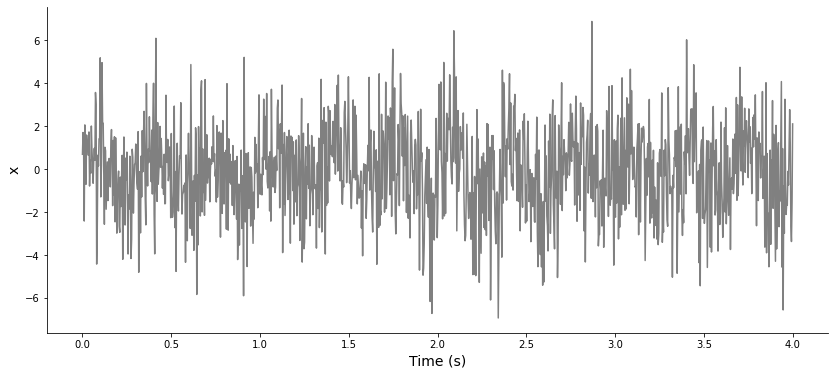

In [114]:
fig, ax = plt.subplots(figsize=(14,6))

duration, fs = 4, 300
time = np.linspace(0, duration, duration*fs)

# create a 3Hz signal
freq = 3
signal = np.sin(2*np.pi*time*freq)

# create noise with std=2
rng = np.random.default_rng(1)
noise = rng.normal(0, 2, size=len(time))

#compose signal and noise
x = signal + noise

# plot
ax.plot(time, x, color='gray', alpha=1)

ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('x', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.show()


Now lets compute the Discrete Fourier Transform of this signal. We will vary the only parameter; the number of points (NFFT) used to sample the discrete transform Eqn (2). 

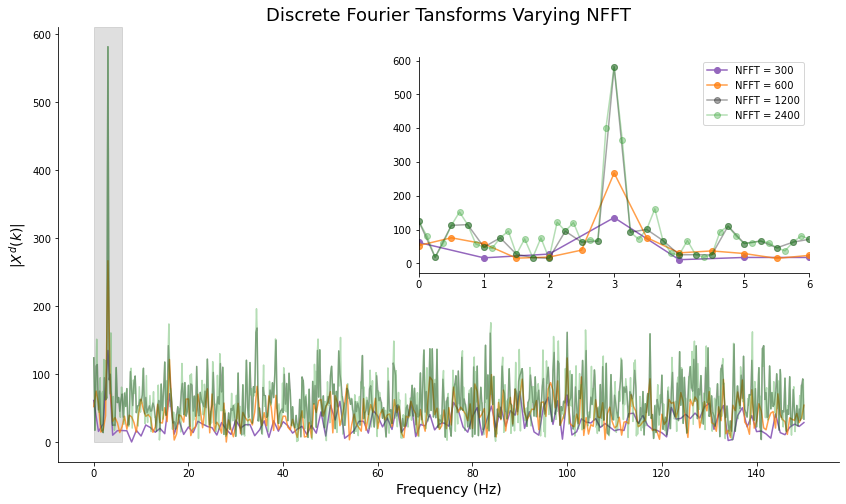

In [91]:
# plot the magnitude of DFT of x -> |X^d[k]| for different NFFTs

# We'll vary the nffts and correspondingly plot them each with different colors and lineprops
NFFTs = [300, 600, 1200, 2400]
colors = ['tab:purple', 'tab:orange', 'k', 'tab:green']
alphas = [1, .75, .35, .35]

# create a figure and inset
fig, ax = plt.subplots(figsize=(14,8))
axinset = inset_axes(ax, width="50%", height=3, loc=1, borderpad=3)
axarr = [ax, axinset]

# compute and plot each DFT
for nfft, color, alpha in zip(NFFTs, colors, alphas):
    
    # compute Fourier transform and Fourier frequencies
    x_f = np.abs(np.fft.rfft(x, n=nfft))
    x_freqs = np.fft.rfftfreq(nfft, d=1/fs)
    
    # plot DFTs making sure to label the nfft used
    axarr[0].plot(x_freqs, x_f, color, alpha=alpha, label='NFFT = {}'.format(nfft))
    axarr[1].plot(x_freqs, x_f, color, alpha=alpha, marker='o', label='NFFT = {}'.format(nfft))

#add rectangle patch and set inset zoom
rect = Rectangle((0,0), 6, axarr[0].get_ylim()[-1], color='gray', alpha=.25)
axarr[0].add_patch(rect)
axarr[1].set_xlim([0,6])

# configure plot
[ax.spines.top.set_visible(False) for ax in axarr]
[ax.spines.right.set_visible(False) for ax in axarr]
axarr[0].set_ylabel(r'$|X^d(k)|$', fontsize=14)
axarr[0].set_xlabel('Frequency (Hz)', fontsize=14)
axarr[1].legend()
axarr[0].set_title('Discrete Fourier Tansforms Varying NFFT', fontsize=18)
plt.show()

Ok, so lets explain what we are seeing here. First, we see the 3 Hz from the sinusoidal component of the signal. Second, <b>we see different curves for each NFFT. Why?</b> Two things, the resolution = fs / NFFT so <b>as we increase the NFFT our resolution gets sharper</b>. In this case the resolutions are 1 (purple), 0.5 (orange), 0.25 (gray) and 0.125 (green). Second, <b>we see amplitude differences at 3 Hz and other frequencies when NFFT < samples </b>. This occurs because the NFFT=300 and 600 are below the total number of samples = 4 secs * 300 Hz = 1200 samples. <b>When this happens the signal x is truncated</b>. So for example when NFFT=300 we are using only the first 300 samples of x and throwing away the remaining 900! Thus for NFFT < samples data is discarded. Lastly, <b>what happens when NFFT > samples like the green curve NFFT=2400?</b> In this case the signal is zero-padded. This leads to an <b>interpolation of the frequencies</b>. This interpolation does not give you more data or more information.

Now that we understand what the Fourier Transform is doing for us we are going to set aside these findings and examine the Autocorrelation function. We'll comeback to the DFT shortly so make sure you understand what it does.

## Autocorrelation